In [1]:
import funzioni as fx
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Bidirectional, BatchNormalization, LSTM, Dropout, Dense, Conv1D, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall
import tensorflow_addons as tfa

tot_ticker = 500
bilanciamento = 1
batch_size = 2052
soglia = 0.5
class_weights = {0: 2, 1: 1}

print("Versione TensorFlow:", tf.__version__)
print("Versione CUDA:", tf.sysconfig.get_build_info()['cuda_version'])
print("Versione cuDNN:", tf.sysconfig.get_build_info()['cudnn_version'])
import psutil

def print_memory_usage():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpu, 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("nessuna GPU")

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and

FileNotFoundError: [Errno 2] No such file or directory: 'dati/X_500_1.npy'

In [ ]:
def crea_modello():
    model = Sequential()
    
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(fx.n_timesteps, fx.n_features)))
    model.add(BatchNormalization())  
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.5)) 
    model.add(LSTM(50))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())   
    model.add(Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())   
    model.add(Dense(1, activation='sigmoid'))    
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=1, average='macro', threshold=soglia), Precision(), Recall()])
    
    return model

def cyclic_learning_rate(epoch, lr):
    # Definisci i tuoi valori massimi e minimi per il learning rate
    max_lr = 0.001
    min_lr = 0.0001
    step_size = 20 # Questo è il numero di epoche per un ciclo completo
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    new_lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x))
    
    # Stampa il learning rate corrente per controllo
    print(f"Learning Rate for Epoch {epoch}: {new_lr}")
    
    return new_lr

# Crea il callback di LearningRateScheduler
clr_callback = LearningRateScheduler(cyclic_learning_rate)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_precision', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_precision', mode='max', patience=10, restore_best_weights=True, verbose=1)

callbacks = [reduce_lr, early_stopping]

model = crea_modello()  


history = model.fit(X, Y, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=callbacks, class_weight=class_weights)

2023-11-06 12:24:39.562620: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3059011200 exceeds 10% of free system memory.
2023-11-06 12:24:42.227283: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3059011200 exceeds 10% of free system memory.


Epoch 1/100
311/311 [==============================] - 32s 84ms/step - loss: 1.6430 - f1_score: 0.2831 - precision: 0.7581 - recall: 0.6499 - val_loss: 0.8427 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
311/311 [==============================] - 24s 79ms/step - loss: 0.6365 - f1_score: 0.2549 - precision: 0.8186 - recall: 0.6985 - val_loss: 0.6007 - val_f1_score: 0.0000e+00 - val_precision: 0.9280 - val_recall: 0.1831 - lr: 0.0010
Epoch 3/100
311/311 [==============================] - 24s 78ms/step - loss: 0.6228 - f1_score: 0.2605 - precision: 0.8209 - recall: 0.7076 - val_loss: 0.4604 - val_f1_score: 0.2243 - val_precision: 0.8208 - val_recall: 0.7247 - lr: 0.0010
Epoch 4/100
311/311 [==============================] - 25s 79ms/step - loss: 0.6167 - f1_score: 0.2713 - precision: 0.8240 - recall: 0.7129 - val_loss: 0.4633 - val_f1_score: 0.2558 - val_precision: 0.8318 - val_recall: 0.6788 - lr: 0.0010
Epoch 5/100
311/311 [===

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 116, 128)          6528      
                                                                 
 batch_normalization (BatchN  (None, 116, 128)         512       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 116, 100)          91600     
                                                                 
 dropout (Dropout)           (None, 116, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

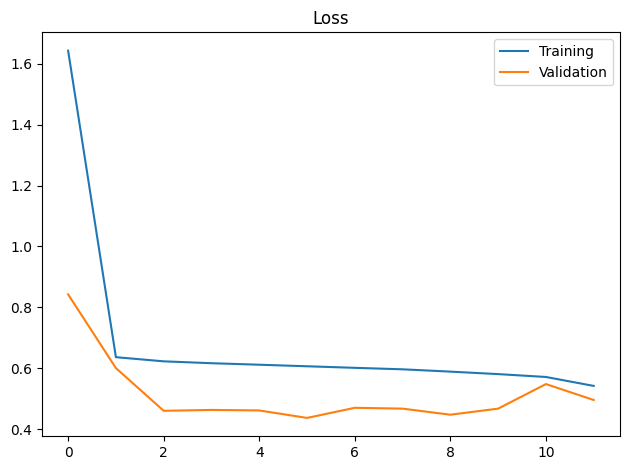

In [ ]:
import matplotlib.pyplot as plt
model_history = pd.DataFrame(history.history)
num_epochs = model_history.shape[0]
plt.plot(np.arange(0, num_epochs), model_history['loss'], label="Training")
plt.plot(np.arange(0, num_epochs), model_history['val_loss'], label="Validation")
plt.legend()
plt.title('Loss')
plt.tight_layout()
plt.show()

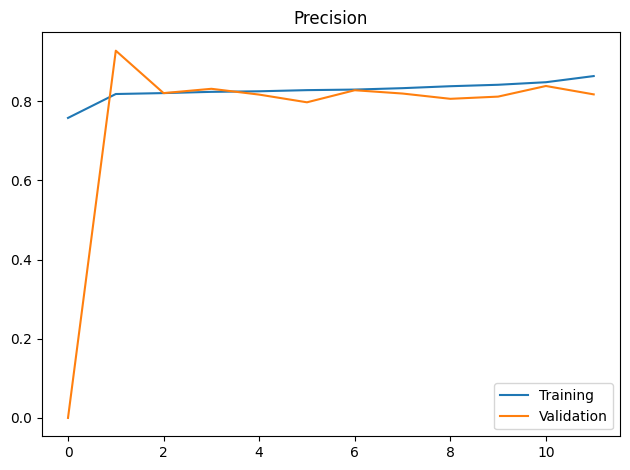

In [ ]:
plt.plot(np.arange(0, num_epochs), model_history['precision'], label="Training")
plt.plot(np.arange(0, num_epochs), model_history['val_precision'], label="Validation")
plt.legend()
plt.title('Precision')
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
ticker = yf.download("BTG", start='2010-01-01', end='2023-10-01', progress=True)
ticker.index = ticker.index.date
print("Calcolo indicatori ticker", flush=True)
ticker = fx.crea_indicatori(ticker)
ticker = fx.imposta_target(ticker)
ticker.dropna(axis=0, inplace=True)
print("Definizione features e target", flush=True)
idx, X, Y, scalers = fx.to_XY(ticker, fx.features_prezzo, fx.features_da_scalare_singolarmente, fx.features_meno_piu, fx.features_candele, fx.features_no_scala, fx.elenco_targets, fx.n_timesteps, 1, bilanciamento=0)
print(f'X.shape: {X.shape}')
print(f'Y.shape: {Y.shape}')
print(f'ticker.shape: {ticker.shape}')

[*********************100%%**********************]  1 of 1 completed
Calcolo indicatori ticker
Definizione features e target
X.shape: (3221, 120, 10)
Y.shape: (3221, 1)
ticker.shape: (3340, 53)


In [ ]:
pred = model.predict(X, batch_size=batch_size, verbose=1, use_multiprocessing=True)
pred_binary = (pred > soglia).astype(int)
result = model.evaluate(X, Y, batch_size=batch_size, verbose=1, use_multiprocessing=True, return_dict=True)
result

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step - loss: 0.3864 - f1_score: 0.0000e+00 - precision: 0.8446 - recall: 0.1902


{'loss': 0.386400431394577,
 'f1_score': 0.0,
 'precision': 0.8445596098899841,
 'recall': 0.1901983618736267}

In [ ]:
pd.set_option('display.max_columns', None)
ris = pd.DataFrame(np.concatenate([Y, pred_binary], axis=1), columns=['Y', 'Prev'], index=idx)
ris = pd.merge(left=ris, right=ticker, how='left', left_index=True, right_index=True)
temp = ris[(ris['Prev'] == 1) & (ris['Y'] == 0)]
temp.tail()

,Y,Prev,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_20,EMA_50,EMA_100,PSARaf,PSARr,PSAR,MACD,MACDh,MACDs,TSI,TSIs,SUPERT,SUPERTd,ADX,TRIX,TRIXs,AROONOSC,ATR,CMF,ROC_10,KVO,KVOs,VHF,OBV,Perc_Max_High_Futuro_20d,Perc_Drawdown_20d,EMA_20_5d,EMA_20_10d,EMA_20_15d,EMA_20_20d,EMA_50_5d,EMA_50_10d,EMA_50_15d,EMA_50_20d,Close_5d,Close_10d,Close_15d,Close_20d,EMA_5_5d,EMA_5_10d,EMA_5_15d,EMA_5_20d,DM_OSC,VTX_OSC,VI_OSC,Target
2023-01-17,0.0,1.0,4.09,4.10,3.99,4.01,3.871400,7741800,4.010511,3.787027,3.585182,3.503799,0.16,0,3.795766,0.201845,0.041039,0.160807,28.783074,20.951426,3.684300,1,22.775859,0.426913,0.325326,90.0,0.140230,0.295417,12.324938,7.566334e+05,521722.445740,0.503106,-28950900.0,2.444985,18.581912,3.917664,3.963572,3.917415,3.778903,3.681627,3.746821,3.766325,3.731927,4.14,3.97,3.79,3.43,4.110108,4.017998,3.840436,3.558535,21.086411,0.468401,465.397766,False
2023-01-18,0.0,1.0,4.09,4.12,4.04,4.05,3.910018,11039800,4.023674,3.812072,3.603410,3.514615,0.16,0,3.858844,0.208662,0.038284,0.170378,28.731875,22.062919,3.684300,1,24.010695,0.451077,0.349293,90.0,0.138070,0.209621,10.054351,9.178689e+05,578314.799519,0.496932,-17911100.0,2.444985,19.070909,3.943601,3.973708,3.906232,3.741865,3.701563,3.759495,3.767645,3.718518,4.19,4.07,3.80,3.39,4.136739,4.035332,3.826957,3.502357,20.970715,0.514925,466.395271,False
2023-01-19,0.0,1.0,4.02,4.16,3.95,4.13,3.987252,14315300,4.059116,3.842351,3.624061,3.526801,0.16,0,3.911829,0.218291,0.038330,0.179960,29.473944,23.121637,3.684300,1,24.652421,0.474618,0.373831,85.0,0.143208,0.214814,6.718352,1.132778e+06,657523.784095,0.398809,-3595800.0,4.228858,17.661693,3.958496,3.966689,3.879924,3.704544,3.717188,3.765005,3.762247,3.704067,4.10,3.90,3.63,3.35,4.124493,3.990221,3.761305,3.451571,16.240169,0.476703,468.370578,False
2023-01-20,0.0,1.0,4.10,4.18,4.06,4.16,4.016216,6860200,4.092744,3.872604,3.645078,3.539340,0.16,0,3.950000,0.227526,0.038052,0.189473,30.347077,24.153843,3.698231,1,25.314408,0.497268,0.398350,80.0,0.141550,0.208501,8.051947,1.166105e+06,730178.286634,0.401274,3264400.0,2.195126,20.487803,3.965306,3.949861,3.855170,3.667921,3.729455,3.765985,3.756669,3.689005,4.03,3.79,3.62,3.32,4.092995,3.923481,3.714203,3.407714,16.258371,0.472527,467.644192,False
2023-01-25,0.0,1.0,4.11,4.19,4.10,4.19,4.045179,7473800,4.136739,3.943601,3.701563,3.574549,0.16,0,4.010000,0.242038,0.029242,0.212796,30.602928,26.406455,3.729630,1,26.568872,0.545640,0.468093,100.0,0.138286,0.356173,6.887754,1.017794e+06,812994.808173,0.392638,11096100.0,1.703156,21.654503,3.973708,3.906232,3.741865,3.560995,3.759495,3.767645,3.718518,3.640065,4.07,3.80,3.39,3.24,4.035332,3.826957,3.502357,3.298582,14.619206,0.418440,465.969761,False


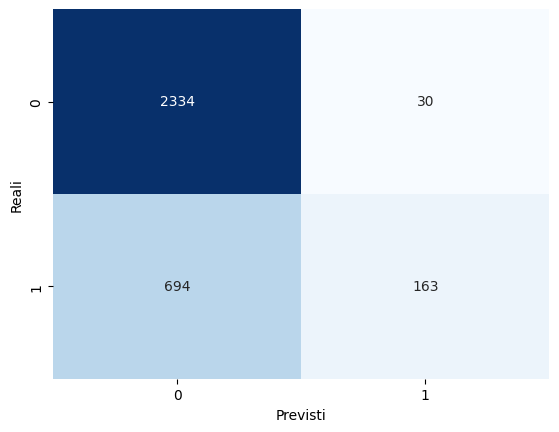

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
matrice = confusion_matrix(Y, pred_binary)

# Visualizza come heatmap
sns.heatmap(matrice, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsti')
plt.ylabel('Reali')
plt.show()

In [ ]:
model.save("model240.h5")

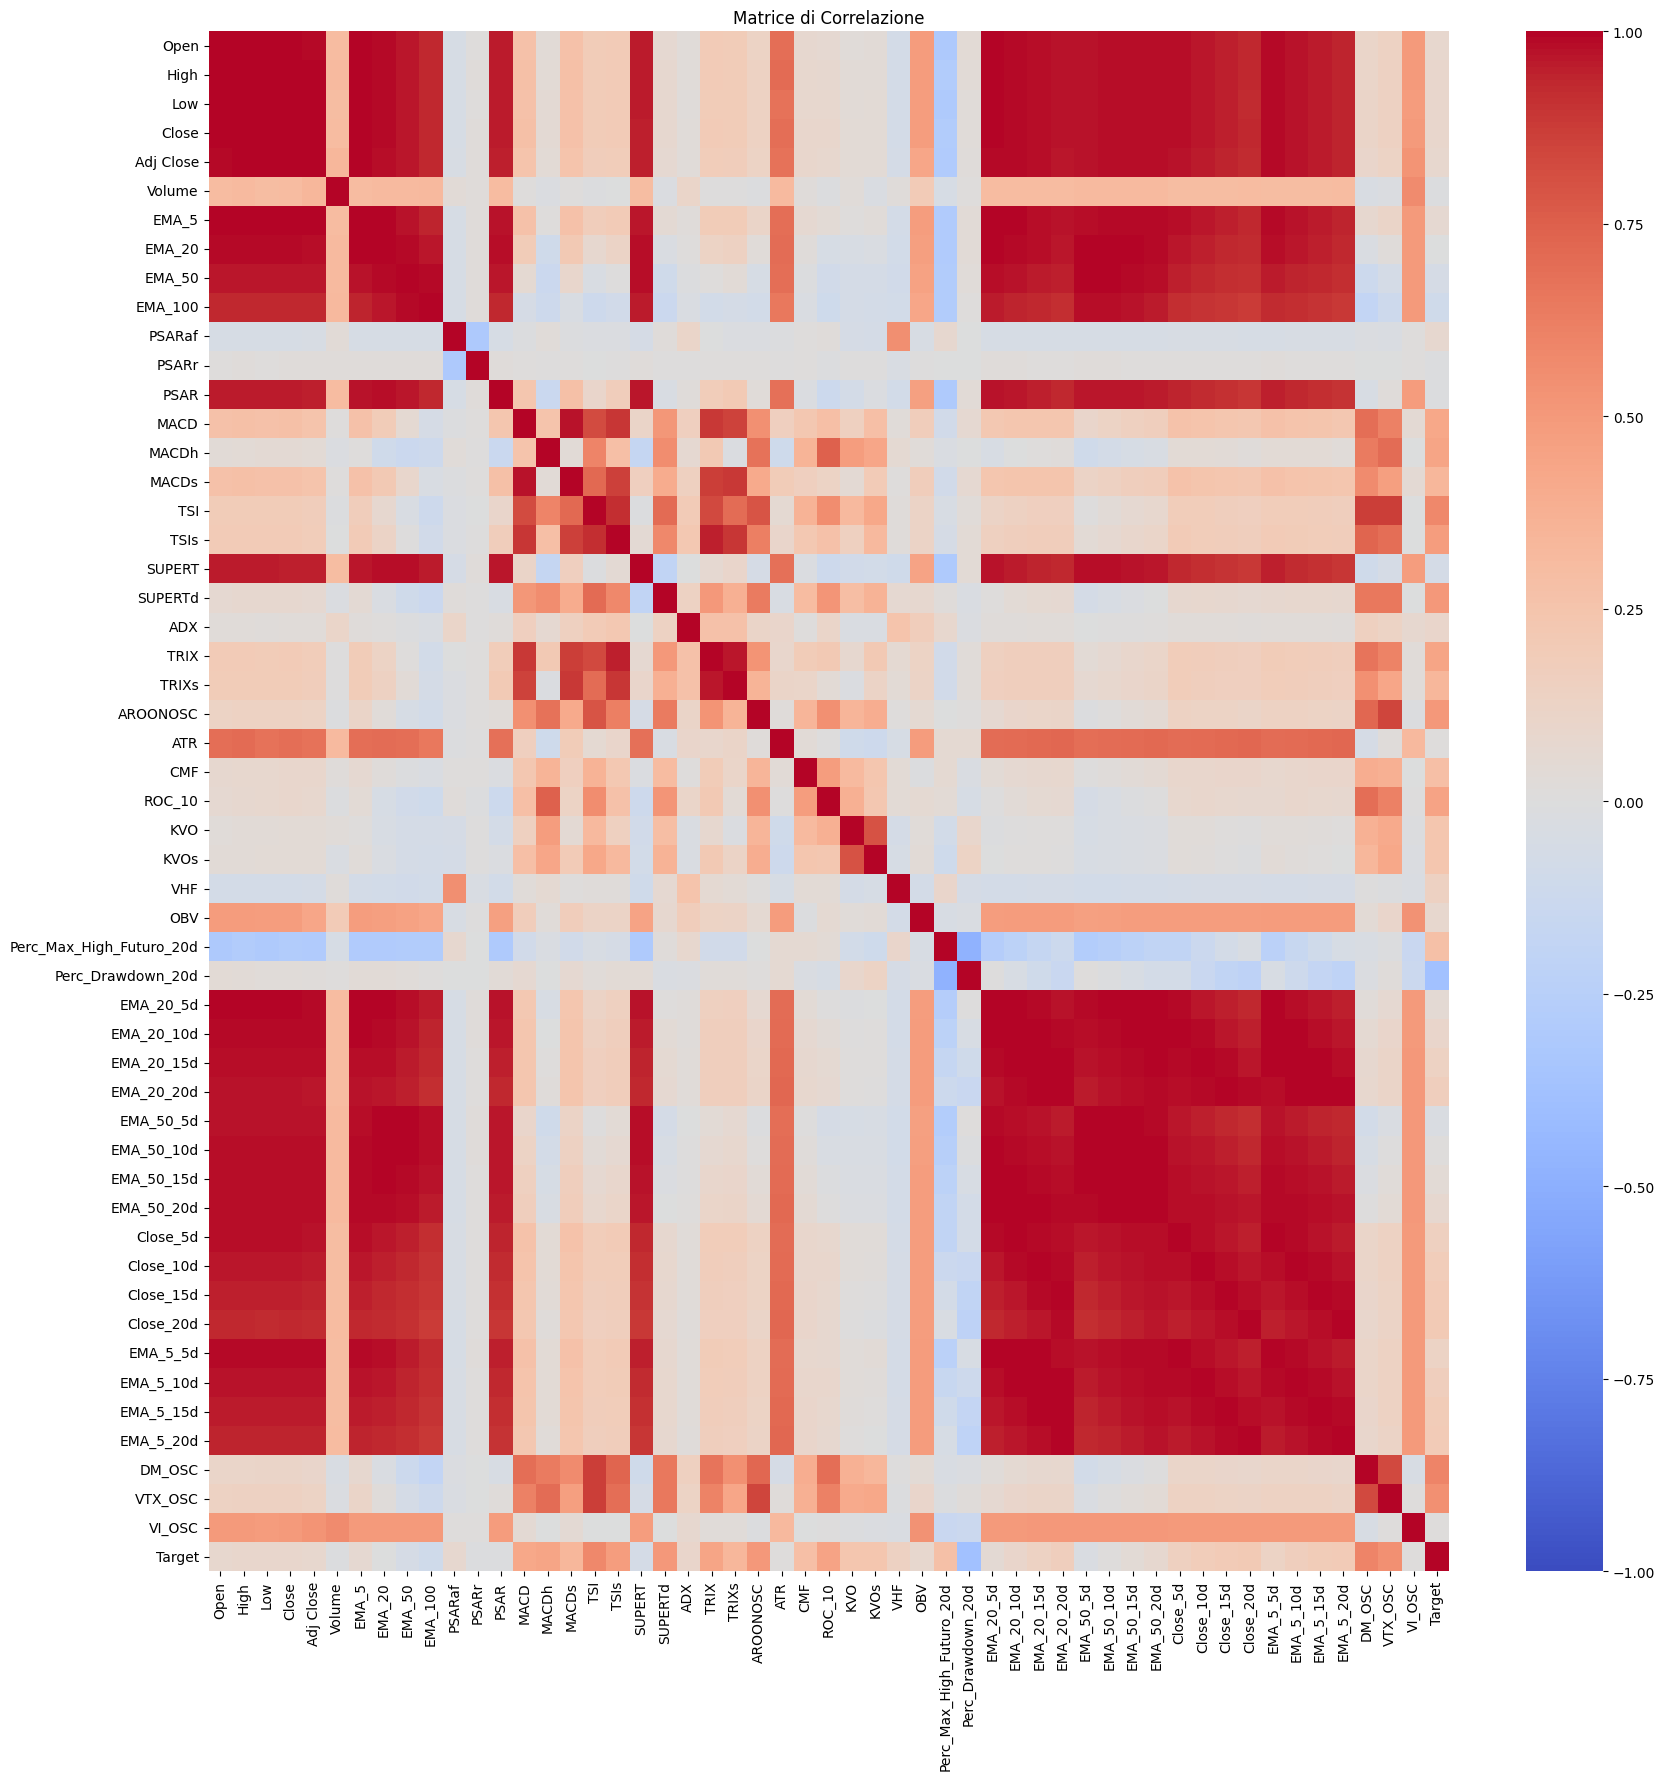

In [ ]:
correlation_matrix = ticker.corr()
plt.figure(figsize=(20,20)) 
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice di Correlazione")
plt.show()